# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|OK|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|OK|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|OK|


### dataset
1. [songys/Chatbot_data](https://github.com/songys/Chatbot_data)
  * 챗봇 트레이닝용 문답 페어 11,823개
  * 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

### 적용할 알고리즘
1. Transformer 모델


## 문제 정의  

> Transformer Model를 기반으로 한 인코더-디코더 구조를 바탕으로 한국어 챗봇 만들기  
> 전처리 토크나이저 : SubwordTextEncoder 사용

## 분석환경

In [208]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.6.0


## Step 1. 데이터 수집하기

In [210]:
train_data = pd.read_csv('./data/ChatbotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


* 결측치 확인

In [211]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


* 중복데이터 확인  
  * Q에 대해서 161개의 중복이 존재하나, 해당Q에 대한 A는 다름.
  * 답이 정해져 있는 경우가 아니므로, 중복 제거하지 않음

In [212]:
train_data.duplicated().sum()
train_data.duplicated(subset=['Q']).sum()
train_data.duplicated(subset=['A']).sum()

0

161

4044

In [213]:
mask = train_data.duplicated(subset=['Q']) == True
train_data[mask]

train_data[train_data['Q'] == train_data.loc[196,'Q']]
train_data[train_data['Q'] == train_data.loc[235,'Q']]
train_data[train_data['Q'] == train_data.loc[1294]['Q']]

,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


,Q,A,label
195,고양이 키우고 싶어,자신을 먼저 키우세요.,0
196,고양이 키우고 싶어,가족들과 상의해보세요.,0


,Q,A,label
234,공시 준비 힘들어,합격 기원해요!,0
235,공시 준비 힘들어,잘 될 거예요.,0


,Q,A,label
1293,돈 벌고 싶어,저도요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0


In [214]:
MAX_SAMPLES = len(train_data)
print('샘플의 개수 :', len(train_data))

샘플의 개수 : 11823


## Step 2. 데이터 전처리하기

1. 문장에서 단어와 구두점 사이에 공백 추가
2. 모든 특수 문자 제거하지 않음  
   샘플 데이터를 봤을 때, 한글, 알파벳, 숫자 포함되어 있어서, 특별히 제거하지 않음
3. 전체 샘플 개수(11823개)의 questions, answers 추출

In [215]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  #sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [216]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  for i in range(MAX_SAMPLES):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs.append(preprocess_sentence(train_data['Q'].values[i]))
    outputs.append(preprocess_sentence(train_data['A'].values[i]))

  return inputs, outputs 

In [217]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


* 임의의 샘플 확인

In [218]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [219]:
print('전처리 후의 질문 샘플: {}'.format(questions[:5]))
print('전처리 후의 답변 샘플: {}'.format(answers[:5]))

전처리 후의 질문 샘플: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
전처리 후의 답변 샘플: ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## Step 3. SubwordTextEncoder 사용하기
  * 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징 하기

#### 단어장(Vocabulary)만들기

In [220]:
import tensorflow_datasets as tfds

# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [221]:
tokenizer.vocab_size

8173

In [222]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [223]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8173]
종료 토큰 번호 : [8174]
단어 집합의 크기 : 8175


#### 정수 인코딩(Integer encoding)과 패딩(padding)

In [224]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [225]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[21]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5763, 610, 2492, 4164]
기존 문장: 가스비 장난 아님


In [226]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5763 ----> 가스
610 ----> 비 
2492 ----> 장난 
4164 ----> 아님


In [227]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [228]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [229]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [230]:
# 22번 샘플을 임의로 출력
print(questions[21])
print(answers[21])

[8173 5763  610 2492 4164 8174    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8173 2356 7513    7 6276   97    1 8174    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


#### 교사 강요(Teacher Forcing) 사용하기

In [231]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [232]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8173 3841   74 7891    1 8174    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8173 3841   74 7891    1 8174    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3841   74 7891    1 8174    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


## Step 4. 모델 구성하기

In [233]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [234]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [235]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [236]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [237]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [238]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [239]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [240]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [241]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [242]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


#### 모델 생성

* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [189]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

* 하이퍼파리미터 
   * num_layers = 6
   * d-model = 512
   * num_heads = 8
   * ff_units = 512 

In [243]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13653504    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실 함수(Loss function)

In [244]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### 커스텀 된 학습률(Learning rate)

In [245]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0, 0.5, 'Learning Rate')

Text(0.5, 0, 'Train Step')

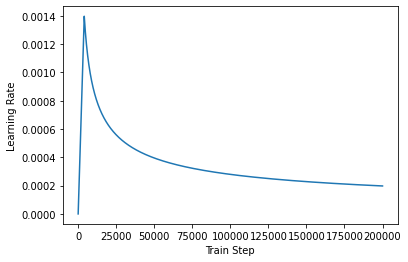

In [246]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일

In [247]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

* EPOCHS = 10 인 경우
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [128]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 27s 56ms/step - loss: 1.4489 - accuracy: 0.0265
Epoch 2/10
185/185 [==============================] - 10s 56ms/step - loss: 1.1780 - accuracy: 0.0493
Epoch 3/10
185/185 [==============================] - 11s 57ms/step - loss: 1.0061 - accuracy: 0.0504
Epoch 4/10
185/185 [==============================] - 10s 57ms/step - loss: 0.9285 - accuracy: 0.0542
Epoch 5/10
185/185 [==============================] - 10s 56ms/step - loss: 0.8703 - accuracy: 0.0577
Epoch 6/10
185/185 [==============================] - 10s 56ms/step - loss: 0.8099 - accuracy: 0.0618
Epoch 7/10
185/185 [==============================] - 10s 56ms/step - loss: 0.7435 - accuracy: 0.0678
Epoch 8/10
185/185 [==============================] - 10s 55ms/step - loss: 0.6708 - accuracy: 0.0757
Epoch 9/10
185/185 [==============================] - 10s 55ms/step - loss: 0.5922 - accuracy: 0.0843
Epoch 10/10
185/185 [==============================] - 10s 55ms/step - loss: 0.510

* EPOCHS = 50 인 경우
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [171]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 17s 55ms/step - loss: 1.4498 - accuracy: 0.0276
Epoch 2/50
185/185 [==============================] - 10s 55ms/step - loss: 1.1794 - accuracy: 0.0493
Epoch 3/50
185/185 [==============================] - 10s 55ms/step - loss: 1.0105 - accuracy: 0.0506
Epoch 4/50
185/185 [==============================] - 10s 54ms/step - loss: 0.9306 - accuracy: 0.0543
Epoch 5/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8710 - accuracy: 0.0577
Epoch 6/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8106 - accuracy: 0.0618
Epoch 7/50
185/185 [==============================] - 10s 53ms/step - loss: 0.7440 - accuracy: 0.0679
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.6702 - accuracy: 0.0756
Epoch 9/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5914 - accuracy: 0.0845
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.509

* EPOCHS = 80 인 경우
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [194]:
EPOCHS = 80
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/80
185/185 [==============================] - 15s 54ms/step - loss: 1.4542 - accuracy: 0.0307
Epoch 2/80
185/185 [==============================] - 10s 54ms/step - loss: 1.1815 - accuracy: 0.0494
Epoch 3/80
185/185 [==============================] - 10s 54ms/step - loss: 1.0070 - accuracy: 0.0505
Epoch 4/80
185/185 [==============================] - 10s 54ms/step - loss: 0.9305 - accuracy: 0.0540
Epoch 5/80
185/185 [==============================] - 10s 54ms/step - loss: 0.8713 - accuracy: 0.0575
Epoch 6/80
185/185 [==============================] - 10s 54ms/step - loss: 0.8104 - accuracy: 0.0618
Epoch 7/80
185/185 [==============================] - 10s 53ms/step - loss: 0.7437 - accuracy: 0.0678
Epoch 8/80
185/185 [==============================] - 10s 53ms/step - loss: 0.6706 - accuracy: 0.0757
Epoch 9/80
185/185 [==============================] - 10s 54ms/step - loss: 0.5906 - accuracy: 0.0843
Epoch 10/80
185/185 [==============================] - 10s 54ms/step - loss: 0.508

185/185 [==============================] - 10s 54ms/step - loss: 0.0028 - accuracy: 0.1743


* EPOCHS = 50 인 경우
* 하이퍼파리미터 
   * num_layers = 6
   * d-model = 512
   * num_heads = 8
   * ff_units = 512 

In [248]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 57s 219ms/step - loss: 1.3456 - accuracy: 0.0229
Epoch 2/50
185/185 [==============================] - 40s 216ms/step - loss: 1.0782 - accuracy: 0.0485
Epoch 3/50
185/185 [==============================] - 40s 217ms/step - loss: 0.9827 - accuracy: 0.0508
Epoch 4/50
185/185 [==============================] - 40s 217ms/step - loss: 0.9392 - accuracy: 0.0528
Epoch 5/50
185/185 [==============================] - 40s 217ms/step - loss: 0.9037 - accuracy: 0.0550
Epoch 6/50
185/185 [==============================] - 40s 217ms/step - loss: 0.8653 - accuracy: 0.0571
Epoch 7/50
185/185 [==============================] - 40s 217ms/step - loss: 0.8250 - accuracy: 0.0591
Epoch 8/50
185/185 [==============================] - 40s 217ms/step - loss: 0.7793 - accuracy: 0.0620
Epoch 9/50
185/185 [==============================] - 40s 217ms/step - loss: 0.7278 - accuracy: 0.0659
Epoch 10/50
185/185 [==============================] - 40s 217ms/step - l

## Step 5. 모델 평가하기

In [129]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [131]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

* EPOCH 10 인 경우 임의의 문장으로 테스트
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [145]:
sentence_generation('3박4일 놀러가고 싶다')

입력 : 3박4일 놀러가고 싶다
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

In [134]:
sentence_generation('고양이 키우고 싶어')

입력 : 고양이 키우고 싶어
출력 : 자신을 더 사랑해주세요 .


'자신을 더 사랑해주세요 .'

In [137]:
sentence_generation('공시 준비 힘들어')

입력 : 공시 준비 힘들어
출력 : 많이 지쳤나봐요 .


'많이 지쳤나봐요 .'

In [138]:
sentence_generation('영화볼래?')

입력 : 영화볼래?
출력 : 화장실 가세요 .


'화장실 가세요 .'

In [139]:
sentence_generation('고민이있어')

입력 : 고민이있어
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

In [140]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 제가 들어드릴게요 .


'제가 들어드릴게요 .'

In [141]:
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 먼저 다가가 보세요 .


'먼저 다가가 보세요 .'

In [142]:
sentence_generation('게임하고싶다')

입력 : 게임하고싶다
출력 : 잘할 수 있을 거예요 .


'잘할 수 있을 거예요 .'

In [143]:
sentence_generation('게임하자')

입력 : 게임하자
출력 : 맛있게 드세요 .


'맛있게 드세요 .'

In [146]:
sentence_generation('오늘날씨 어때?')

입력 : 오늘날씨 어때?
출력 : 제가 들어드릴게요 .


'제가 들어드릴게요 .'

* EPOCH = 50인 경우 임의의 문장으로 테스트
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [173]:
sentence_generation('3박4일 놀러가고 싶다')

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .


'여행은 언제나 좋죠 .'

In [174]:
sentence_generation('고양이 키우고 싶어')

입력 : 고양이 키우고 싶어
출력 : 가족들과 상의해보세요 .


'가족들과 상의해보세요 .'

In [175]:
sentence_generation('공시 준비 힘들어')

입력 : 공시 준비 힘들어
출력 : 잘 될 거예요 .


'잘 될 거예요 .'

In [176]:
sentence_generation('영화볼래?')

입력 : 영화볼래?
출력 : 안됐네요 .


'안됐네요 .'

In [177]:
sentence_generation('고민이있어')

입력 : 고민이있어
출력 : 좋은 일이 생길 거예요 .


'좋은 일이 생길 거예요 .'

In [178]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 그럴수록 당신이 힘들 거예요 .


'그럴수록 당신이 힘들 거예요 .'

In [179]:
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 저는 오래 살고 싶어요 .


'저는 오래 살고 싶어요 .'

In [180]:
sentence_generation('게임하고싶다')

입력 : 게임하고싶다
출력 : 저도요 !


'저도요 !'

In [181]:
sentence_generation('게임하자')

입력 : 게임하자
출력 : 게임하세요 !


'게임하세요 !'

In [182]:
sentence_generation('오늘날씨 어때?')

입력 : 오늘날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

* EPOCH = 80인 경우 임의의 문장으로 테스트
* 하이퍼파리미터 
   * num_layers = 2
   * d-model = 256
   * num_heads = 8
   * ff_units = 512 

In [195]:
sentence_generation('3박4일 놀러가고 싶다')

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .


'여행은 언제나 좋죠 .'

In [196]:
sentence_generation('고양이 키우고 싶어')

입력 : 고양이 키우고 싶어
출력 : 자신을 먼저 키우세요 .


'자신을 먼저 키우세요 .'

In [197]:
sentence_generation('공시 준비 힘들어')

입력 : 공시 준비 힘들어
출력 : 잘 될 거예요 .


'잘 될 거예요 .'

In [198]:
sentence_generation('영화볼래?')

입력 : 영화볼래?
출력 : 영화는 데이트의 기본이죠 .


'영화는 데이트의 기본이죠 .'

In [199]:
sentence_generation('고민이있어')

입력 : 고민이있어
출력 : 이른 고백이지만 고민해보세요 .


'이른 고백이지만 고민해보세요 .'

In [200]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 그럴수록 당신이 힘들 거예요 .


'그럴수록 당신이 힘들 거예요 .'

In [201]:
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 저는 고민이 없어요 .


'저는 고민이 없어요 .'

In [202]:
sentence_generation('게임하고싶다')

입력 : 게임하고싶다
출력 : 게임하세요 !


'게임하세요 !'

In [203]:
sentence_generation('게임하자')

입력 : 게임하자
출력 : 게임하세요 !


'게임하세요 !'

In [204]:
sentence_generation('오늘날씨 어때?')

입력 : 오늘날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

* EPOCH = 50인 경우 임의의 문장으로 테스트
* 하이퍼파리미터 
   * num_layers = 6
   * d-model = 512
   * num_heads = 8
   * ff_units = 512 

In [250]:
sentence_generation('3박4일 놀러가고 싶다')

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠 .


'여행은 언제나 좋죠 .'

In [251]:
sentence_generation('고양이 키우고 싶어')

입력 : 고양이 키우고 싶어
출력 : 가족들과 상의해보세요 .


'가족들과 상의해보세요 .'

In [252]:
sentence_generation('공시 준비 힘들어')

입력 : 공시 준비 힘들어
출력 : 잘 될 거예요 .


'잘 될 거예요 .'

In [253]:
sentence_generation('영화볼래?')

입력 : 영화볼래?
출력 : 살짝 물어보세요 .


'살짝 물어보세요 .'

In [254]:
sentence_generation('고민이있어')

입력 : 고민이있어
출력 : 말씀해주세요 .


'말씀해주세요 .'

In [255]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 꼭 하고 싶은 게 있을 필요는 없어요 .


'꼭 하고 싶은 게 있을 필요는 없어요 .'

In [256]:
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [257]:
sentence_generation('게임하고싶다')

입력 : 게임하고싶다
출력 : 지금도 늦지 않았어요 .


'지금도 늦지 않았어요 .'

In [258]:
sentence_generation('게임하자')

입력 : 게임하자
출력 : 학교 다닐 때가 좋은 거예요 .


'학교 다닐 때가 좋은 거예요 .'

In [259]:
sentence_generation('오늘날씨 어때?')

입력 : 오늘날씨 어때?
출력 : 살짝 내려보는것도 괜찮을거 같아요 .


'살짝 내려보는것도 괜찮을거 같아요 .'

## 회고
* 트랜스포머 논문 (Attention is All You Need)를 제대로 이해하지 못하고, LMS code와 딥러닝을 이용한 자연어 처리 입문 책의 코드를 거의 그대로 사용했기에, 좀 더 공부가 필요함
* 트랜스포머를 사용한 seq2seq 모델은, 하이퍼파라미터 변경 없이, epoch 변경만으로 성능이 향상 되었음. 
  * epoch=10 인 경우는 임의의 문장 뿐만 아니라, 훈련용 데이터 입력 시에도 적절하지 않은 답변을 함
  * epoch=50 인 경우는 훈련용 데이터 입력 시에는 훈련용 답변으로 답변하고, 임의의 문장 입력시에는 대부분 적절한 답변을 하였지만, 적절하지 못한 답변을 하는 경우도 있음
  * epoch=80 인 경우는 epoch=50 인 경우와 비슷한 결과임.
* 논문의 내용과 동일하게 하이퍼파라미터 변경 시에는 성능에 차이가 없었음 
   * num_layers = 6
   * d-model = 512
* 더 많은 데이터로 학습시키면, 적절한 답변을 할 수 있을 것으로 판단 됨  
* RNN을 사용하지 않고 attention만 사용하니까, 확실히 학습 속도가 빠름

## 참고 문헌
* [딥러닝을 이용한 자연어 처리 입문](https://wikidocs.net/89786)
* [Transformer paper 설명](https://www.youtube.com/watch?v=AA621UofTUA&t=2s)